### $\color{indianred}{\text{ПРВА ВЈЕЖБА ИЗ АСТРОСТАТИСТИКЕ}} $

### Пар информација

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

У овом ноутбуку ће бити мало више теорије, него програмирања, због увода у предмет. У документу који 

сте добили од професорке има један линк ка гит-у, и тамо је малтене читав садржај курса који треба да 

прођемо. Ми ћемо у овом, и наредним терминима вјежби, радити готово идентичне проблеме, уз неке додатке.

Правим ове ноутбукове да бисте имали материјале за испит на српском, да мало изађемо из оквира - додатни 

проблеми, те да филтрирамо шта нам заправо служи, а шта не. Ове вјежбе су довољне за полагање испита.

### Теоријски увод

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Нека је $x$ скаларна величина која се мјери $N$ пута да би се формирао скуп података.

- $x_i$ је појединачно мјерење за $i = 1, \dots, N$,
- $\{x_i\}$ означава скуп свих $N$ мјерења која чине скуп података.  

Подаци могу бити реални бројеви, дискретне ознаке (нпр. стрингови), или чак „недостајуће вриједности” (тад  

користимо $NaN$).  



$\blacksquare$ Генерално, покушавамо да *процијенимо* $h(x)$, *стварну* расподјелу вјероватноће из које  

су узети подаци $\{x_i\}$ случајно одабрани.  

- $h(x)$ представља **функцију густине вјероватноће** (енгл. *Probability Density Function* - PDF),  

при чему је $h(x)dx$ дефинисана као вјероватноћа да случајна промјенљива $x$ поприми вриједност у интервалу  

$[x, x + dx]$. Ова расподјела може имати различите нивое - од класичне расподјеле физичких параметара  

(нпр. дистрибуције црвеног помака космичких извора) до расподјеле неодређености мјерења која уводи додатну  

стохастичку компоненту у посматране вриједности.  

- Интеграл од $h(x)$ одређује **кумулативну функцију дистрибуције** (енгл. *Cumulative Distribution Function* - CDF),  

    дефинисану као:  
      $$
      H(x) = \int_{-\infty}^{x} h(x')dx'.
      $$  

- Инверзна функција од $H(x)$ је тзв. квантилна функције и омогућава одређивање вриједности $x$ испод које  

  се налази одређени проценат укупне расподјеле (нпр. $90\%$).  

- Иако $h(x)$ представља „идеализовану” расподјелу података (познату и као популациона функција густине),  

експериментално доступни подаци омогућавају само апроксимацију путем емпиријске функције густине  

вјероватноће, означене са $f(x)$. Дакле, $f(x)$ може бити схваћена као модел за $h(x)$. У теоријском  

лимиту бесконачне количине података важи $f(x) \to h(x)$, али у реалним условима ефекти несигурности мјерења  

и ограничене величине узорка узрокују одступања. Додатно, емпиријска кумулативна дистрибуција означава  

се са $F(x)$.  

- У ситуацијама када настојимо да конструишемо физички модел функције $h(x)$, говоримо о параметарској

методологији. У том случају, одабир математичке форме модела омогућава генерисање нових синтетичких  

података који би требало да репродукују основне карактеристике посматраних величина. Насупрот томе, уколико  

не  постављамо експлицитне претпоставке о форми функције $h(x)$, већ је емпиријски апроксимирамо из  

података, процес се квалификује као непараметарски – циљ је дескриптивна карактеризација података  

без експлицитног  моделовања феномена који их генерише.  

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KernelDensity
from astropy.visualization import hist
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import pylab as plb

### Програмирање - 1. дио

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Испод ћемо генерисати случајне податке, комбинацијом пет Кошијевих расподјела са различитим параметрима.

Укратко, Кошијева расподјела је континуална расподјела вјероватноће. Њена функције густине вјероватноће је:

$$
f(x,\, \gamma) = \frac{1}{\pi \gamma} \cdot \frac{1}{1 + \left( \frac{x - x_0}{\gamma} \right)^2},
$$

гдје су:
- $x_0$ - параметар локације (медијана),
- $\gamma$ - параметар скале (половина ширине на пола максималне густине),
- $x$ - случајна промјењива.

Неке од главних особина су што нема очекивану вриједност, ни варијансу. Има "дуге репове", што значи да се

често јављају екстремне вриједности. Користи се као примјер "проблематичне" расподјеле у статистици.

- - -

Враћамо се на задатак. Правимо листе тројки ($\mu,\,\gamma,\,f$), гдје су:

$\mu$ - средња вриједност (*mean*) Кошијеве расподјеле;

$\gamma$ - ширина (*scale parameter*) Кошијеве расподјеле;

$f$ - тежински фактор, који одређује допринос сваке компоненте у укупној расподјели.

Дакле, ми сад генеришемо податке, али их у реалности добијамо мјерењем.

In [10]:
random_state = np.random.RandomState(seed=0) # генератор случајних бројева (важи репродуктивност)
N = 2000 # укупан број генерисаних података

mu_gamma_f = [(5, 1.0, 0.1), # листа од пет тројки
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]

hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x) # функција густине вјероватноће
                          for (mu, gamma, f) in mu_gamma_f])

# генерисање случајних промјењивих
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])

random_state.shuffle(x) # "мијешање" података

x = x[x > -15]
x = x[x < 25]

In [11]:
print(len(x))
print(x[:10])

1965
[ 8.95259664  6.94253336 11.85750297  7.96736763  8.33979377  9.10403052
  9.0348829   9.0006615  12.0682028  12.43803661]


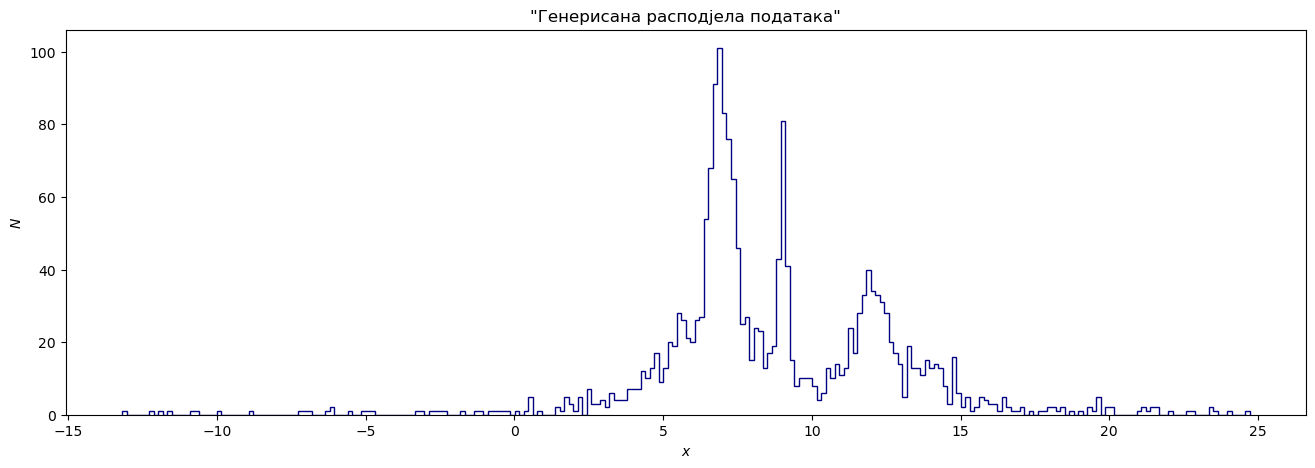

In [15]:
plt.figure(figsize=(16,5))
plt.hist(x, bins=250, color='navy', histtype='step')
plt.xlabel(r'$x$')
plt.ylabel(r'$N$')
plt.title('"Генерисана расподјела података"')
plt.show()

Прелазимо на мало комплекснији приступ проблему. Корисно је дефинисати шта је то *log-likelihood*:

"лог-вјероватноћа" је логаритамска вриједност функције вјероватноће. Ако имамо скуп података 

$x = \{x_1, x_2, ..., x_N\}$, а модел каже да су ти подаци узорци из неке дистрибуције са функцијом 

густине вјероватноће $p(x | \theta)$, гдје $\theta$ представља параметре модела, онда је вјероватноћа

за све податке дефинисана као:

$$
L(\theta) = P(x | \theta) = \prod_{i=1}^{N} p(x_i | \theta).
$$

Овдје се заправо показује колико су вјероватни подаци $x$ ако су генерисани моделом са параметрима $\theta$.

Производ вјероватноћа се често рачуна са врло малим бројевима (нумерички проблеми). Због тога, у пракси се

чешће користи формула:

$$
\log L(\theta) = \sum_{i=1}^{N} \log p(x_i | \theta).
$$

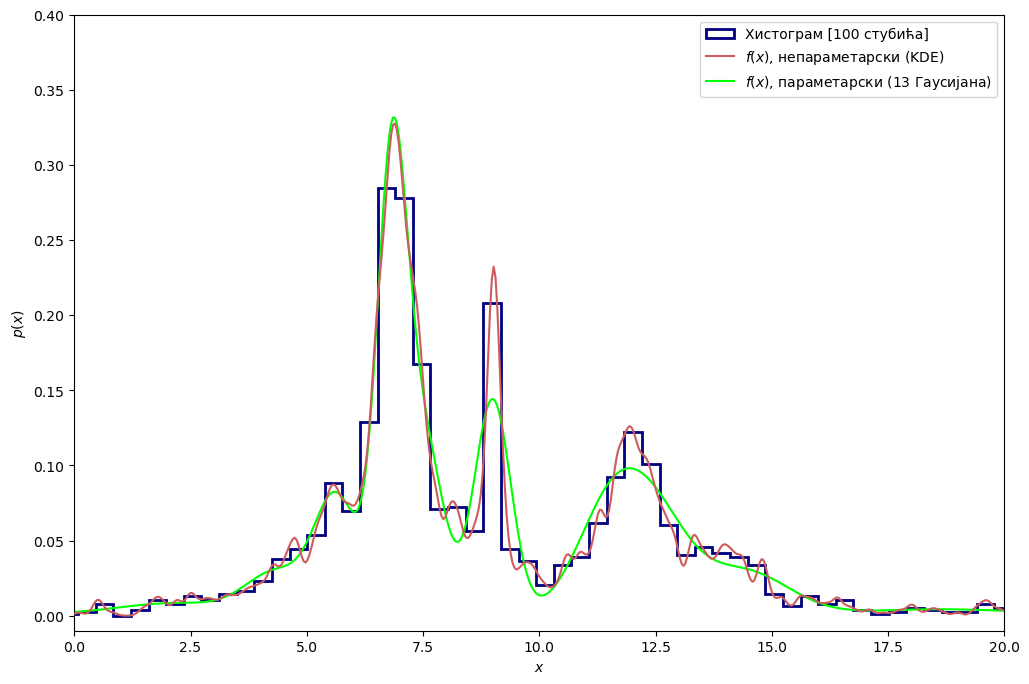

In [17]:
plt.figure(figsize=(12,8))
xgrid = np.linspace(-10, 30, 1000) # генерисање мреже тачака за цртање густине

# права расподјела - у реалности, имамо само узорке података
if False:
    plt.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label='$h(x)$, Generating Distribution')

# хистограм
if True:
    plt.hist(x, density=True, color='navy', bins=100, histtype='step', lw=2, label='Хистограм [100 стубића]')

# непараметарска метода процјене функције густине - Kernel Density Estimation (KDE)
if True:
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian') # Гаусов кернел
    kde.fit(x[:, None]) # додавање података
    dens_kde = np.exp(kde.score_samples(xgrid[:, None])) # рачунање вриједности густине
    plt.plot(xgrid, dens_kde, '-', color='indianred', zorder=3, # KDE процијењена функција
            label='$f(x)$, непараметарски (KDE)')

# параметарска метода која апроксимира расподјелу помоћу мјешавине гаусијана (Gaussian Mixture Model)
if True:
    n_components = 13
    gmm = GaussianMixture(n_components=n_components).fit(x.reshape(-1, 1)) # креирање модела
    logprob = gmm.score_samples(xgrid.reshape(-1, 1)) # рачунање log-likelihood
    fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1))) # конверзија у праве вјероватноће
    plt.plot(xgrid, fx(np.array(xgrid)), '-', color='lime', # параметарски процијењена функција
            label=f'$f(x)$, параметарски ({n_components} Гаусијана)')

plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
plt.xlabel('$x$')
plt.xlim(0, 20)
plt.ylim(-0.01, 0.4001)
plt.show()

In [20]:
print('h(x) - права расподјела: ', hx(19)) 
print('f(x) за непараметарски модел: ', np.exp(kde.score_samples(np.atleast_2d(19)))) 
print('f(x) за параметарски модел: ', fx(np.array([19]))) 

h(x) - права расподјела:  0.0026156532919017587
f(x) за непараметарски модел:  [0.00204107]
f(x) за параметарски модел:  [0.00420275]


### Теорија - наставак

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Прије него се вратимо на кодирање, површно прелазимо још неке теме.

$\blacksquare$ Уопштено, у нашој анализи присутни су сљедећи кораци:

1. процјена $f(x)$ из неког реалног (често вишедимензионалног) скупа података,  

2. опис $f(x)$ и и њене неизвјесности, 

3. упоређивање са моделима $h(x)$,

4. на крају, **тумачење/предвиђање** нових мјерења.  

---

#### Грешке и неодређености

Грешке су *системске пристрасности* које се не могу ублажити прикупљањем великог 

броја података. Статистичке неизвјесности, су пак, резултат насумичних неизвјесности у мјерењу.

Термин "грешка" се користи за обје дефиниције, па имамо **статистичке грешке** (*error bars*) или

**систематске грешке** (*biases*). **Расподјеле статистичких грешака** које варирају од тачке до

тачке називају се *хетероскедастичке грешке*. Супротно томе, имамо *хомоскедастичке грешке*.

---

#### Вјероватноћа

$p(A)$ је вјероватноћа догађаја $A$ (густина вјероватноће у $A$). На примјер, вјероватноћа да

је посматрани објекат галаксија. Вјероватноћа одражава наше тренутно знање о објекту.  


$\blacksquare$ Аксиоми вјероватноће (Колмогоров) су: 

1. $p(A) \geq 0 \quad \forall A$,
2. $p(\Omega) = 1$, гдје је $\Omega$ скуп свих могућих исхода, тј. збир/интеграл свих могућих исхода је једнак 1, 
3. $p(\bigcup_{i=1}^{\infty} A_i) = \sum_{i=1}^{\infty} p(A_i)$ ако су сви догађаји независни.   

Уколико имамо два догађаја, вјероватноћа да ће се или $A$ или $B$ догодити (што може укључивати оба)

је *унија* и дата је формулом:  

$$
p(A \cup B) = p(A) + p(B) - p(A \cap B).
$$

Вјероватноћа да ће се оба догађаја догодити је пресјек $p(A \cap B)$, који је дат формулом:

$$
p(A \cap B) = p(A|B) p(B) = p(B|A) p(A),
$$

гдје је $p(A|B)$ условна вјероватноћа.  

Закон *укупне вјероватноће* каже да, за независне $B_i$ важи:

$$
p(A) = \sum_i p(A | B_i) p(B_i).
$$

Даље, сљедећа једнакост је увијек тачна:

$$
p(A, B) = p(A|B) p(B) = p(B|A) p(A).
$$

Ако су $A$ и $B$ *независни*, онда важи:

$$
p(A|B) = p(A) \quad \text{и} \quad p(B|A) = p(B),
$$

па се пресјек догађаја своди на:

$$
p(A, B) = p(A) p(B).
$$

---

$\blacksquare$ ПРИМЈЕР: класичан проблем са куглицама у врећи 

Ако имамо врећу са 5 куглица (3 жуте и 2 плаве) и желимо да израчунано вјероватноћу да извучемо 2 жуте

куглице заредом, користимо једнакост:

$$
p(Y_1, Y_2) = p(Y_1) p(Y_2\,|\,Y_1)
$$

$\blacksquare$ Случај без враћања куглице у врећу

$p(Y_1) = \frac{3}{5}$, јер имамо једнаку вјероватноћу да извучемо било коју од 5 куглица.

Ако не враћамо куглицу, онда се укупан број куглица смањује на 4, па је $p(Y_2\,|\,Y_1) = \frac{2}{4}$.

Дакле, вјероватноћа да извучемо 2 жуте заредом, без враћања је $p(Y_1, Y_2) = \frac{3}{5}\cdot\frac{2}{4} = \frac{3}{10}$.


$\blacksquare$ Случај са враћањем куглице у врећу

Ако након извлачења вратимо прву куглицу у врећу, онда остаје исти број куглица, па је: $p(Y_2\,|\,Y_1) = \frac{3}{5} = p(Y_2)$.

Дакле, вјероватноћа да извучемо 2 жуте куглице заредом са враћањем је $p(Y_1, Y_2) = \frac{3}{5} \cdot \frac{3}{5} = \frac{9}{25}$

У *првом случају* (без враћања), $A$ и $B$ нису независни, јер избор прве куглице утиче на избор друге.

Што се тиче другог случаја (са враћањем), $A$ и $B$ су независни, јер избор прве куглице не утиче на избор друге.

---

#### Бајесова теорема

Важи једнакост:

$$
p(x,y) = p(x|y)p(y) = p(y|x)p(x).
$$

Тзв. маргиналну вјероватноћу можемо дефинисати као:

$$
p(x) = \int p(x, y) dy,
$$

гдје *маргинално* значи пројектовање на једну осу (интеграција преко непотребне промјенљиве).

Маргинална вероватноћа  $x$ може се записати као:

$$
p(x) = \int p(x|y) p(y) dy.
$$

Али пошто важи: $p(x|y) p(y) = p(y|x) p(x)$, можемо записати:

$$
p(y|x) = \frac{p(x|y) p(y)}{p(x)} = \frac{p(x|y) p(y)}{\int p(x|y) p(y) dy}.
$$

Једнакост изнад је формулација Бајесове теореме.

---

$\blacksquare$ ПРИМЈЕР: ковид тестови

Бајесово правило можемо користити за разумијевање *лажно позитивних* и *лажно негативних* резултата теста.  

Тест може бити *позитиван* ($T = 1$) или *негативан* ($T = 0$), а особа може *имати болест* ($D = 1$)

или је *немати* ($D = 0$).  Постоје четири могуће комбинације:  


\begin{aligned}
T = 0;  D = 0 \quad &\text{(истинито негативан - true negative)} \\
T = 0;  D = 1 \quad &\text{(лажно негативан - false negative)} \\
T = 1;  D = 0 \quad &\text{(лажно позитиван - false positive)} \\
T = 1;  D = 1 \quad &\text{(истинито позитиван - true positive)} \\
\end{aligned}


Ако све друге околности остану исте, постоји $50\%$ шансе да особа буде погрешно дијагностикована. 

Међутим, вјероватноћа саме болести и тачност теста нису насумични. Ако су стопе лажно позитивних

и лажно негативних случајева дате као:

$$
p(T = 1 | D = 0) = \varepsilon_{FP},\, p(T = 0 | D = 1) = \varepsilon_{FN},
$$

онда су истините позитивне и истините негативне стопе:

$$
p(T = 0 | D = 0) = 1 - \varepsilon_{FP},\,p(T = 1 | D = 1) = 1 - \varepsilon_{FN}.
$$

Можемо да претпоставимо неке вриједности: $\varepsilon_{FP} = 0.02$ и $\varepsilon_{FN} = 0.001$.

\begin{array}{c|c|c}
     & T = 0 & T = 1 \\
    \hline
    D = 0 & 1 - \varepsilon_{FP} & \varepsilon_{FP} \\
    D = 1 & \varepsilon_{FN} & 1 - \varepsilon_{FN} \\
\end{array}

Матрица $p(T|D)$ представља вјероватноће исхода теста ($T$) у зависности од присуства болести ($D$).

Ако имамо *a priori* знање о томе *колико је болест вjероватна*, можемо то узети у обзир:

$$p(D = 1) = \varepsilon_D,$$

а затим имамо и $p(D = 0) = 1 - \varepsilon_D$. Претпоставимо да је *вjероватноћа болести*: $\varepsilon_D = 0.01$.

Ако је резултат теста позитиван, упитно је колика је вjероватноћа да особа заиста има болест. Питање је

да ли је то $98\%$ јер је $\varepsilon_{FP} = 0.02$. Ту долазимо до Бајесове теорије вјероватноће.

Према Бајесу, имамо:

$$ p(D = 1 | T = 1) = \frac{p(T = 1 | D = 1) p(D = 1)}{p(T = 1)}, $$  

гдје је  

$$ p(T = 1) = p(T = 1 | D = 0) p(D = 0) + p(T = 1 | D = 1) p(D = 1). $$   

Дакле, добијамо:  

$$ p(D = 1 | T = 1) = \frac{(1 - \varepsilon_{FN}) \varepsilon_D}{\varepsilon_{FP} (1 - \varepsilon_D) + (1 - \varepsilon_{FN}) \varepsilon_D}$$  

$$\implies p(D=1 |T =1) \approx \frac{\varepsilon_D}{\varepsilon_{FP} + \varepsilon_D}.$$


У посљедњој апроксимацији претпостављамо да су све вриједности $\varepsilon$ мале. Ово значи да, ако желимо

поуздану дијагнозу, морамо да смањимо лажно позитивну стопу $\varepsilon_{FP}$.  Имамо стопу болести од $1\%$, 

$ \varepsilon_D = 0.01 $  и лажно позитивну стопу од $2\%$, $ \varepsilon_{FP} = 0.02 $. Даље, слиједи:  

$$ p(D = 1 | T = 1) = \frac{0.01}{0.02 + 0.01} = 0.333.$$  

Фактички, ако тестирамо $1000$ људи:  

- $10$ људи заиста има болест ($1000 \cdot 0.01$),
- још $20$ људи ће добити лажно позитиван резултат ($1000\cdot 0.02$).  

Дакле, у узорку од $30$ људи који су добили позитиван тест, само $1/3$ заиста има болест - не $98\%$!

### Програмирање - 2. дио

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Испод су два кратка кода. Први је везан за условну вјероватноћу, а други за маргиналне вјероватноће.

Примјери су показног типа, врло поједностављени, а овај дио теорије се детаљније ради на предавањима.

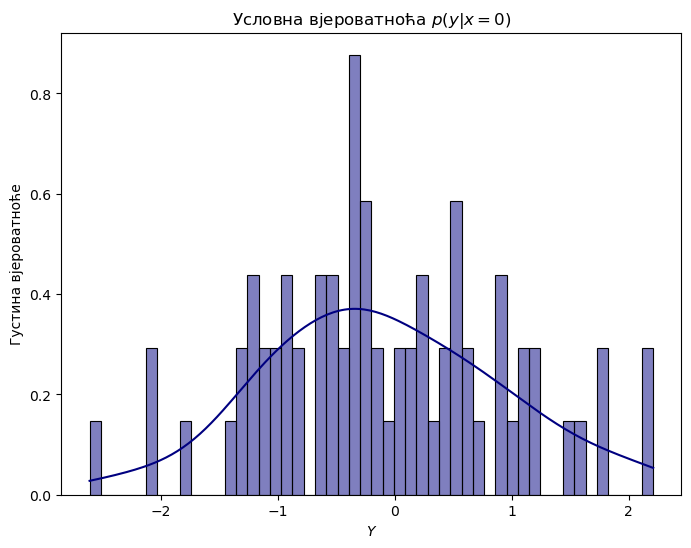

In [3]:
mean = [0, 0]  # средње вриједности
cov = [[1, 0.3], [0.3, 1]]  # коваријациона матрица
x, y = np.random.multivariate_normal(mean, cov, 1000).T  # генерисање узорака

# фисксирање једне варијабле и приказивање условне расподјеле
x_fixed = 0  
x_range = 0.1  # интервал за селекцију података
y_given_x = y[(x > x_fixed - x_range) & (x < x_fixed + x_range)] # селектовање

plt.figure(figsize=(8, 6))
sns.histplot(y_given_x, kde=True, bins=50, color='navy', stat='density')
plt.xlabel("$Y$")
plt.ylabel('Густина вјероватноће')
plt.title(fr'Условна вјероватноћа $p(y|x={x_fixed})$')
plt.show()

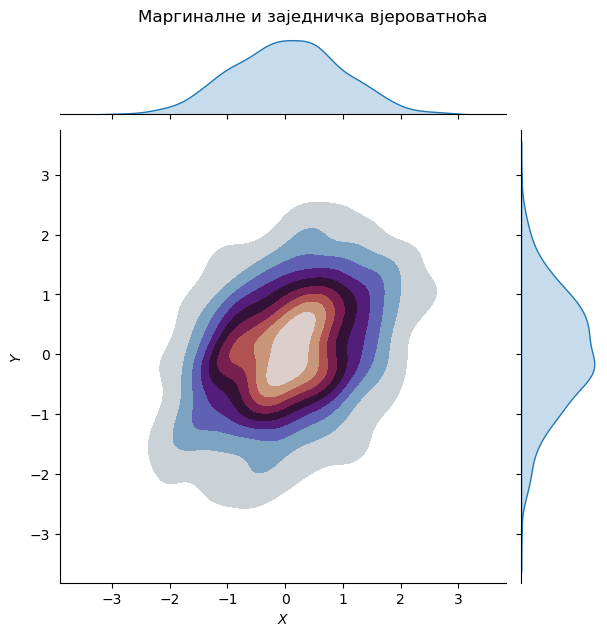

In [21]:
# генерисање података
mean = [0, 0]  # средње вриједности 
cov = [[0.9, 0.3], [0.3, 0.9]]  # коваријациона матрица
x, y = np.random.multivariate_normal(mean, cov, 1000).T # генерисање узорака

# приказ заједничке и маргиналних вјероватоћа
g = sns.jointplot(x=x, y=y, kind="kde", fill=True, cmap='twilight')
g.set_axis_labels('$X$', '$Y$')
plt.suptitle('Маргиналне и заједничка вјероватноћа', y=1.02)
plt.show()

### Теорија - додатак

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

#### Трансформације случајних промјенљивих 

Ако је $x$ случајна промјенљива, онда је и $f(x)$ случајна промјенљива за било коју функцију $f$.  

У циљу трансформисања расподјеле вјероватноће, када користимо функције случајних промјенљивих,

може се једноставно примијенити тзв. *закон одржања вјероватноће*, тј.

$$
p(x) dx = p(y) dy,
$$

гдје је $y = f(x)$. Добијамо:
$$
p(y) = \Bigg| \frac{dx}{dy} \Bigg| p(x).
$$

---

$\blacksquare$ ПРИМЈЕР

Нека је $x$ случајна промјенљива узоркована из *униформне расподјеле* у опсјегу између $0$ и $1$.  

Важи $p(x) = \frac{1}{1 - 0} = 1$. Претпоставимо да вршимо трансформацију $y = e^x$. Добијамо:
$$
p(y) = \Bigg| \frac{dy}{dx} \Bigg|^{-1},\, p(x) = \frac{1}{y}.
$$

### Програмирање - 3. дио

<hr style="border: none; height: 2px; background-color: red; opacity: 0.5;" />

Сад прелазимо на нешто практичније - *Monty Hall problem*. У питању је телевизијски квиз. Имамо троје

врата, иза једних је аутомобил, иза преосталих двоје је коза. Водитељ емисије пита учеснике да изаберу

једна врата, али да их не отварају. Затим водитељ отвара једна од преосталих врата (која нису изабрана),

а за која је сигурно да имају козу. Водитељ затим играчима нуди прилику да промијене избор.

- Један играч одлучује да промијени избор.

- Други играч остаје при свом првобитном избору.

Сада долази трећи играч који није видио шта се раније дешавало. Он бира врата. Питање је који од тројице

играча има највећу шансу да побиједи. Играчи наравно, играју појединачно.

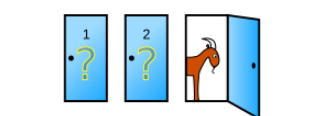

Пробаћемо да симулирамо игру...

In [22]:
def threedoors(which): # симулација рунде игре

    labels = np.arange(3) # називи за врата
    doors = np.zeros(3,dtype=int) # садржај врата
    doors[np.random.choice(labels)] = 1 # непозната врата садрже награду
    choice = np.random.choice(labels) # избор врата
    notchosen = np.delete(labels,choice) # преостала врата

    while True:
        opened = np.random.choice(notchosen) # једна врата су отворена
        if doors[opened]==0: # ако нису "побједничка" врата
            other = int(np.delete(labels,[opened,choice])) # врата која преостају
            break
    
    # различите стратегије
    if which == 'switch': # промјена
        return doors[other]

    elif which == 'keep': # задржавање
        return doors[choice]
 
    elif which == 'external': # трећа особа бира
        picked = np.random.choice([choice,other])
        return doors[picked]

N  = int(1e4) # број рунди
probs = {} # рјечник који чува вјероватноће побједе за сваку стратегију

for which in tqdm(['switch','keep','external']):
    events = [threedoors(which) for i in tqdm(range(N))]
    probs[which] = np.sum(events)/ N

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]


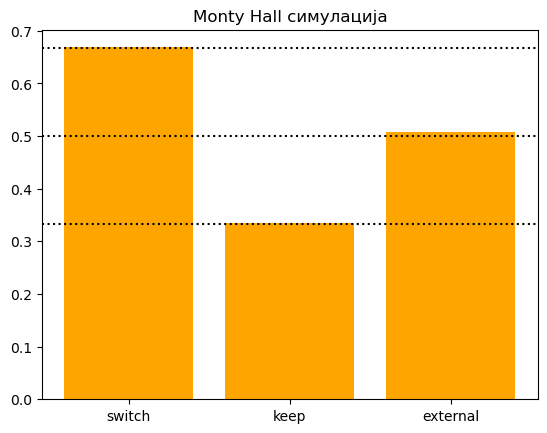

In [23]:
plt.bar([0,1,2], [probs[k] for k in probs.keys()], color='orange');
plt.xticks([0,1,2], probs.keys());

for y in [1/3,1/2,2/3]:
   plt.axhline(y, ls='dotted',c='black')

plt.title('Monty Hall симулација')
plt.show()